In [3]:
import pandas as pd
from transformers import GPT2Tokenizer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import GPT2Tokenizer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import torch
import random
from transformers import GPT2LMHeadModel, GPT2Config, get_linear_schedule_with_warmup
import numpy as np
from transformers import AdamW
import os

**Reference: https://www.kaggle.com/code/ysthehurricane/text-generation-with-gpt2-huggingface**

In [4]:
###### Hyperparameters ######

## General ##

random_seed = 42
train_size = 0.8
random_seed = 42
max_len = 50
bs = 16
tokenizer = GPT2Tokenizer.from_pretrained('gpt2',
                                          bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>',
                                          pad_token='<|pad|>')



configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))


epochs = 10
warmup_steps = 1e2
eps = 1e-8

optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = eps
                )

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')    
print(f"Currently running on {device}")

model.to(device)

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

Currently running on cuda


In [6]:
import torch
from torch.utils.data import Dataset # this is the pytorch class import

class MTGDataset(Dataset):
    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=50):
        self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:
            """
            This loop will iterate through each entry in the flavour text corpus.
            For each bit of text it will prepend it with the start of text token,
            then append the end of text token and pad to the maximum length with the
            pad token.
            """

            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>',
                                       truncation=True,
                                       max_length=max_length,
                                       padding="max_length")

            """
            Each iteration then appends either the encoded tensor to a list,
            or the attention mask for that encoding to a list. The attention mask is
            binary list of 1's or 0's which determine whether the langauge model
            should take that token into consideration or not.
            """

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [7]:
class Dataloader:
    def __init__(self, ds_path, tokenizer=tokenizer):
        self.ds_path = ds_path
        self.tokenizer = tokenizer
        self.ds = None

    def load_data(self):
        self.ds = pd.read_csv(self.ds_path)
        self.ds = self.ds.dropna()
    
    def rename_col(self):
        self.ds = self.ds.rename(columns ={"text": "fortunes"})

    def split_data(self):
        self.train_data, self.val_data = train_test_split(self.ds, train_size=train_size, random_state=random_seed)

    def create_torch_ds(self):
        
        self.train_dataset = MTGDataset(self.train_data["fortunes"], self.tokenizer, max_length=max_len)
        self.val_dataset = MTGDataset(self.val_data["fortunes"], self.tokenizer, max_length=max_len)

    def create_torch_dataloaders(self):
        self.train_dataloader = DataLoader(
            self.train_dataset,
            batch_size = bs,
            shuffle=True
        )

        self.validation_dataloader = DataLoader(
                    self.val_dataset,
                    sampler = SequentialSampler(self.val_dataset),
                    batch_size = bs,
                    shuffle=False
                )
        
        return self.train_dataloader, self.validation_dataloader
    
    def get_training_steps(self, num_epochs):
        return len(self.train_dataloader) * epochs
        
    def loading_pipeline(self):
        print("loading data...")
        self.load_data()
        print("renaming col...")
        self.rename_col()
        print("splitting data...")
        self.split_data()
        print("creating torch datasets...")
        self.create_torch_ds()
        print("creating torch dataloaders...")
        train_loader, val_loader = self.create_torch_dataloaders()
        return train_loader, val_loader

In [8]:
loader = Dataloader(os.path.join('..', 'datasets', 'combined_fortunes-4632.csv'))

train_loader, val_loader = loader.loading_pipeline()

loading data...
renaming col...
splitting data...
creating torch datasets...
creating torch dataloaders...


In [9]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = loader.get_training_steps(num_epochs=warmup_steps),
                                            num_training_steps = loader.get_training_steps(num_epochs=epochs))

scheduler

In [10]:
import torch
import time
import datetime
import random

def format_time(elapsed):
    # Helper function to format elapsed time into hh:mm:ss
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

class ModelTrainer:
    def __init__(self, model, train_dataloader, validation_dataloader, optimizer, scheduler, device):
        self.model = model
        self.train_dataloader = train_dataloader
        self.validation_dataloader = validation_dataloader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.training_stats = []
        self.best_val_loss = float('inf')  # Initialize best validation loss as infinity
        self.epochs_no_improve = 0  # Track epochs with no improvement
        self.early_stop_patience = 3  # Number of epochs to wait for improvement before stopping

    def train(self, epochs, tokenizer):
        total_t0 = time.time()

        for epoch_i in range(epochs):
            self.current_epoch = epoch_i + 1
            print(f'Beginning epoch {self.current_epoch} of {epochs}')

            t0 = time.time()
            total_train_loss = 0
            self.model.train()

            for step, batch in enumerate(self.train_dataloader):
                print(f"Processing Batch: {step}")

                b_input_ids = batch[0].to(self.device)
                b_labels = batch[0].to(self.device)
                b_masks = batch[1].to(self.device)

                self.model.zero_grad()

                outputs = self.model(b_input_ids, labels=b_labels, attention_mask=b_masks)
                loss = outputs[0]

                batch_loss = loss.item()
                total_train_loss += batch_loss

                if step % 5 == 0 and not step == 0:
                    elapsed = format_time(time.time() - t0)
                    print(f'Batch {step} of {len(self.train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')
                    
                    self.model.eval()

                    sample_outputs = self.model.generate(
                                        bos_token_id=random.randint(1, 30000),
                                        do_sample=True,
                                        top_k=50,
                                        max_length=200,
                                        top_p=0.95,
                                        num_return_sequences=1
                                    )
                    for i, sample_output in enumerate(sample_outputs):
                        print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')

                    self.model.train()

                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

            self.avg_train_loss = total_train_loss / len(self.train_dataloader)
            self.training_time = format_time(time.time() - t0)

            print(f'Average Training Loss: {self.avg_train_loss}. Epoch time: {self.training_time}')

            val_loss = self.evaluate(t0)  # Evaluate on the validation set and get validation loss

            # Early Stopping Check
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.epochs_no_improve = 0
                # Save model here if desired
            else:
                self.epochs_no_improve += 1
                if self.epochs_no_improve >= self.early_stop_patience:
                    print(f"No improvement in validation loss for {self.early_stop_patience} consecutive epochs. Stopping training.")
                    break  # Early stopping

        print(f'Total training took {format_time(time.time() - total_t0)}')
        
        return self.model

    def evaluate(self, t0):
        print("\nEvaluating...")

        self.model.eval()
        total_eval_loss = 0

        for batch in self.validation_dataloader:
            b_input_ids = batch[0].to(self.device)
            b_labels = batch[0].to(self.device)
            b_masks = batch[1].to(self.device)

            with torch.no_grad():
                outputs = self.model(b_input_ids, attention_mask=b_masks, labels=b_labels)
                loss = outputs[0]

            total_eval_loss += loss.item()

        avg_val_loss = total_eval_loss / len(self.validation_dataloader)
        validation_time = format_time(time.time() - t0)

        print(f'Validation Loss: {avg_val_loss}. Validation Time: {validation_time}')

        # Record all statistics from this epoch.
        self.training_stats.append({
            'Epoch': self.current_epoch,
            'Training Loss': self.avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': self.training_time,
            'Validation Time': validation_time
        })
        
        return avg_val_loss

In [11]:
#TODO: Check if correctly keeping track of the time

trainer = ModelTrainer(model, train_loader, val_loader, optimizer, scheduler, device)
model = trainer.train(epochs, tokenizer)

Beginning epoch 1 of 10
Processing Batch: 0
Processing Batch: 1
Processing Batch: 2
Processing Batch: 3
Processing Batch: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 5
Batch 5 of 232. Loss:23.930679321289062. Time:0:00:02
Example output:  bipartisan
Processing Batch: 6
Processing Batch: 7
Processing Batch: 8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 9
Processing Batch: 10
Batch 10 of 232. Loss:20.060810089111328. Time:0:00:06
Example output:  increasing
Processing Batch: 11
Processing Batch: 12
Processing Batch: 13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 14
Processing Batch: 15
Batch 15 of 232. Loss:19.432825088500977. Time:0:00:09
Example output: day
Processing Batch: 16
Processing Batch: 17
Processing Batch: 18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 19
Processing Batch: 20
Batch 20 of 232. Loss:19.36772346496582. Time:0:00:12
Example output:  Hang
Processing Batch: 21
Processing Batch: 22
Processing Batch: 23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 24
Processing Batch: 25
Batch 25 of 232. Loss:18.854137420654297. Time:0:00:16
Example output:  foods
Processing Batch: 26
Processing Batch: 27
Processing Batch: 28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 29
Processing Batch: 30
Batch 30 of 232. Loss:15.19267463684082. Time:0:00:19
Example output:  trail
 (
Processing Batch: 31
Processing Batch: 32
Processing Batch: 33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 34
Processing Batch: 35
Batch 35 of 232. Loss:10.906363487243652. Time:0:00:22
Example output: intend () (7,, () () (7) () () () () (7) (7) () () () () () () () () () () () () () () () () () () () ()
Processing Batch: 36
Processing Batch: 37
Processing Batch: 38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 39
Processing Batch: 40
Batch 40 of 232. Loss:9.535661697387695. Time:0:00:25
Example output:  surround the the I the the the I the I the I the I the the the I the the I the the the the the the the the the the the the the I the the the the the I the the the the the the the the the the I the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Processing Batch: 41
Processing Batch: 42
Processing Batch: 43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 44
Processing Batch: 45
Batch 45 of 232. Loss:5.897995471954346. Time:0:00:28
Example output:  reflex (( (A ( (A) (A) (A) (A) (A (A) (A) (A) (A) (A) (A) (A) (A) (A) (A) (A (A) (A (A) (A) (A) (A) (A) ( (A) (A) (A) (A) (A) (A) (A) (A) (A) (A) (A) (A) (A) (A) (A) (A (A (A) ( (A) (A (A) (A) (A) (A) (
Processing Batch: 46
Processing Batch: 47
Processing Batch: 48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 49
Processing Batch: 50
Batch 50 of 232. Loss:4.031284332275391. Time:0:00:31
Example output:  display (screen)
 T Display

"

 THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE
Processing Batch: 51
Processing Batch: 52
Processing Batch: 53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 54
Processing Batch: 55
Batch 55 of 232. Loss:3.340456962585449. Time:0:00:34
Example output:  pastor, and the, and the, and the, and the, and the, and the, and the, and the, and the., and the, and the, and the. and the, and the. and the. and the. and the. and the. and the. and the. and,, and, and the. and the, and the. and, and the,,, and the. and, and the. and the. and the. and the. and the. and the. and the. and, and, and and the, and,,, and the, and the. and the. and the. and the. and
Processing Batch: 56
Processing Batch: 57
Processing Batch: 58


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 59
Processing Batch: 60
Batch 60 of 232. Loss:2.5887508392333984. Time:0:00:37
Example output:  illicit"The United States of America
Processing Batch: 61
Processing Batch: 62
Processing Batch: 63


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 64
Processing Batch: 65
Batch 65 of 232. Loss:1.99421226978302. Time:0:00:38
Example output:  Liberation
 the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Processing Batch: 66
Processing Batch: 67
Processing Batch: 68


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 69
Processing Batch: 70
Batch 70 of 232. Loss:1.7504111528396606. Time:0:00:41
Example output:  Nam
 the the the the


TheThe_Mighty_Marty
the
THE_THE_
THE_
THE_
THE THETHE
the the the
the The_Mighty_Martthe THE_THE_THE_THE_THETHE_THE_The_The_The_Mighty_Marty THE_THETHE_the_the_the_the_the_the_the_the_the_The_The_The_MTHE_theThe_The_The_The_The_The_the_The_THE_The_The_The_The_The_The_The_The_The_The_The_The_The_The_The_The_The_The_The_The_The_The_The_The_The_The_TheTHE_THE_THE
Processing Batch: 71
Processing Batch: 72
Processing Batch: 73


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 74
Processing Batch: 75
Batch 75 of 232. Loss:2.1680188179016113. Time:0:00:44
Example output: ION the and the for the the
Processing Batch: 76
Processing Batch: 77
Processing Batch: 78


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 79
Processing Batch: 80
Batch 80 of 232. Loss:1.5568444728851318. Time:0:00:45
Example output:  glimpse,
 the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Processing Batch: 81
Processing Batch: 82
Processing Batch: 83


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 84
Processing Batch: 85
Batch 85 of 232. Loss:1.7763592004776. Time:0:00:48
Example output:  LaureB:EVER!@#&+END
Processing Batch: 86
Processing Batch: 87
Processing Batch: 88


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 89
Processing Batch: 90
Batch 90 of 232. Loss:1.2900745868682861. Time:0:00:49
Example output: ism or
 shall be in the world, and
 world and the world shall be the
 world and the world shall be the
 world and the world shall be the
 world and the world shall be the
 world and world shall be the
Processing Batch: 91
Processing Batch: 92
Processing Batch: 93


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 94
Processing Batch: 95
Batch 95 of 232. Loss:1.3739900588989258. Time:0:00:51
Example output: oun (,,, ) string [ ] string [ ] string [ ] string [ ] string [ ] string [ ] string string [ ] " string [ ] string [ ] " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " "
Processing Batch: 96
Processing Batch: 97
Processing Batch: 98


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 99
Processing Batch: 100
Batch 100 of 232. Loss:1.3122750520706177. Time:0:00:54
Example output:  electionA day of reckoning for the workers, for the planet and for the planet forPrescription is life, peace and security
Processing Batch: 101
Processing Batch: 102
Processing Batch: 103


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 104
Processing Batch: 105
Batch 105 of 232. Loss:1.3680720329284668. Time:0:00:55
Example output:  crazy. that; in that way; in that way; in that way; in that way; in that way; in that way; in that way; in that way
Processing Batch: 106
Processing Batch: 107
Processing Batch: 108


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 109
Processing Batch: 110
Batch 110 of 232. Loss:1.4771509170532227. Time:0:00:56
Example output:  bench) in the two in the two in the two in the two in the two in the two in the two in the two in the two in the two in the two in the two in the two in the two in four in the that.
Processing Batch: 111
Processing Batch: 112
Processing Batch: 113


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 114
Processing Batch: 115
Batch 115 of 232. Loss:1.2586017847061157. Time:0:00:58
Example output:  incorporated that
The said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the said the the said the said the said the said the said the said the said the said the said the said the said the said the said
Processing Batch: 116
Processing Batch: 117
Processing Batch: 118


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 119
Processing Batch: 120
Batch 120 of 232. Loss:1.3930379152297974. Time:0:01:01
Example output: Peter The man whose has,
 one who has the.
 one who has the. the one who has. the.
 one who has the. the one who has the.
 one who has the. the. the.
 one the. the. the.
 one the. the. the. the.
 one the. the. the.
 one the. the. the. the.
 one the. the. the. the
Processing Batch: 121
Processing Batch: 122
Processing Batch: 123


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 124
Processing Batch: 125
Batch 125 of 232. Loss:1.3464431762695312. Time:0:01:03
Example output: uring-job-work.html
 how to be-tween.
 how to-be- how-to-be.
 how to-be-leaving.
Processing Batch: 126
Processing Batch: 127
Processing Batch: 128


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 129
Processing Batch: 130
Batch 130 of 232. Loss:1.4142740964889526. Time:0:01:04
Example output:  reproductive for male male to male male to male to male to male to male to male to male to male to male to male to male to male to male to male to male to male to male to male to male to for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for
Processing Batch: 131
Processing Batch: 132
Processing Batch: 133


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 134
Processing Batch: 135
Batch 135 of 232. Loss:1.4058609008789062. Time:0:01:07
Example output:  zone(s), a function(s) that returns a function with factors: the factors: the factor.
Processing Batch: 136
Processing Batch: 137
Processing Batch: 138


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 139
Processing Batch: 140
Batch 140 of 232. Loss:1.3946043252944946. Time:0:01:08
Example output:  commitsAffected: false
Processing Batch: 141
Processing Batch: 142
Processing Batch: 143


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 144
Processing Batch: 145
Batch 145 of 232. Loss:1.1446568965911865. Time:0:01:09
Example output:  irony on., the, the, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the. it, the it, the. it, it, the. it, it, the. it, the. it, the. it, the. it
Processing Batch: 146
Processing Batch: 147
Processing Batch: 148


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 149
Processing Batch: 150
Batch 150 of 232. Loss:1.0415399074554443. Time:0:01:12
Example output:  Sahin,, was thousand years; and thousand years, for the thousand thousand years.
Processing Batch: 151
Processing Batch: 152
Processing Batch: 153


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 154
Processing Batch: 155
Batch 155 of 232. Loss:1.0406668186187744. Time:0:01:13
Example output:  Bryan-O-Matic, who living, breathing, breathing-yourself, who is your own person, who is your own person, and
Processing Batch: 156
Processing Batch: 157
Processing Batch: 158


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 159
Processing Batch: 160
Batch 160 of 232. Loss:1.0704110860824585. Time:0:01:14
Example output:  spirits you, that you may be able to.
Processing Batch: 161
Processing Batch: 162
Processing Batch: 163


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 164
Processing Batch: 165
Batch 165 of 232. Loss:1.1382876634597778. Time:0:01:15
Example output:  sees the. attitude about. the attitude about, the attitude about. the attitude about, the attitude about. the attitude about. the attitude about. the attitude about. the attitude about. the attitude about. the attitude about. the attitude attitude in. the attitude attitude attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude the attitude th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 169
Processing Batch: 170
Batch 170 of 232. Loss:1.2922883033752441. Time:0:01:18
Example output:  hungry and and beautiful and and lovely and beautiful and happy, and happiness and happy and happy and happy and beautiful and happy and happy.
 is the and the.
Processing Batch: 171
Processing Batch: 172
Processing Batch: 173


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 174
Processing Batch: 175
Batch 175 of 232. Loss:1.0811129808425903. Time:0:01:19
Example output:  PTI'm not about to be offended by any one of your beliefs, beliefs, or motivations, you must adhere to the beliefs, feelings, and opinions of others.
Processing Batch: 176
Processing Batch: 177
Processing Batch: 178


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 179
Processing Batch: 180
Batch 180 of 232. Loss:0.9904899597167969. Time:0:01:20
Example output: üThis is a joke.
Processing Batch: 181
Processing Batch: 182
Processing Batch: 183


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 184
Processing Batch: 185
Batch 185 of 232. Loss:1.133080244064331. Time:0:01:21
Example output: ruce-foot-tree-dwelling-at-8th-century-century.aspx
 tree-foot-tree.aspx
Processing Batch: 186
Processing Batch: 187
Processing Batch: 188


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 189
Processing Batch: 190
Batch 190 of 232. Loss:1.0021086931228638. Time:0:01:22
Example output:  derivatives (other than in accordance with section, and the in, the company of and the company of the state of, the company of the state of, the and the for of the state of, the and the, the in the state of, the for the in the and the for the it shall be the the the the for the to be in the country it, the the the for the in the in the country of the the state of, the for the it shall be the or to the if it is it shall be or to the if it is the if it is the or to the whether it shall be
Processing Batch: 191
Processing Batch: 192
Processing Batch: 193


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 194
Processing Batch: 195
Batch 195 of 232. Loss:1.0664321184158325. Time:0:01:25
Example output: , it does not.
Processing Batch: 196
Processing Batch: 197
Processing Batch: 198


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 199
Processing Batch: 200
Batch 200 of 232. Loss:0.9973669052124023. Time:0:01:26
Example output:  remembering the; it will, and the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most more of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the most of the best of the most of the most of the best of the most of the most of the most of the best of the most of the best of the best of the most of the best of the most of the best of the best of the best of the best of the best of the best of the best of the best of
Processing Batch: 201
Processing Batch: 202
Processing Batch: 203


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 204
Processing Batch: 205
Batch 205 of 232. Loss:0.9500823020935059. Time:0:01:29
Example output:  SourcesWhat you want to read today is a guide to health, a guide to life.
Processing Batch: 206
Processing Batch: 207
Processing Batch: 208


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 209
Processing Batch: 210
Batch 210 of 232. Loss:1.0274724960327148. Time:0:01:30
Example output: ems and monsters the shall be a the who is the in the shall have the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the more the
Processing Batch: 211
Processing Batch: 212
Pr

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 214
Processing Batch: 215
Batch 215 of 232. Loss:1.0604774951934814. Time:0:01:33
Example output: tz is a an an an that an an an an an a and an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an
Processing Batch: 216
Processing Batch: 217
Processing Batch: 218


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 219
Processing Batch: 220
Batch 220 of 232. Loss:0.8518076539039612. Time:0:01:36
Example output: maticIf you do not love your neighbor as yourself, your love will be less.
Processing Batch: 221
Processing Batch: 222
Processing Batch: 223


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 224
Processing Batch: 225
Batch 225 of 232. Loss:1.0015474557876587. Time:0:01:37
Example output:  syndThe sky is falling.
Processing Batch: 226
Processing Batch: 227
Processing Batch: 228


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 229
Processing Batch: 230
Batch 230 of 232. Loss:0.9537750482559204. Time:0:01:38
Example output:  gam of the the Greek.
Processing Batch: 231
Average Training Loss: 4.654362069892472. Epoch time: 0:01:38

Evaluating...
Validation Loss: 0.9667894449727289. Validation Time: 0:01:40
Beginning epoch 2 of 10
Processing Batch: 0
Processing Batch: 1
Processing Batch: 2
Processing Batch: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 4
Processing Batch: 5
Batch 5 of 232. Loss:0.9278314709663391. Time:0:00:01
Example output:  injuryThe wind's wont blow.
Processing Batch: 6
Processing Batch: 7
Processing Batch: 8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 9
Processing Batch: 10
Batch 10 of 232. Loss:1.3832200765609741. Time:0:00:01
Example output: azaA. But the evil spirits cannot be cured with fire.
Processing Batch: 11
Processing Batch: 12
Processing Batch: 13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 14
Processing Batch: 15
Batch 15 of 232. Loss:1.091537594795227. Time:0:00:02
Example output:  membrane-inhibition the tendency to expand.
 tendency to expand. The tendency to be moved.
Processing Batch: 16
Processing Batch: 17
Processing Batch: 18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 19
Processing Batch: 20
Batch 20 of 232. Loss:1.165763020515442. Time:0:00:03
Example output: ijingIn the last days of his life, he will find great pleasure in your company.
Processing Batch: 21
Processing Batch: 22
Processing Batch: 23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 24
Processing Batch: 25
Batch 25 of 232. Loss:1.0997995138168335. Time:0:00:04
Example output:  castI have tried many different approaches to life...
Processing Batch: 26
Processing Batch: 27
Processing Batch: 28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 29
Processing Batch: 30
Batch 30 of 232. Loss:0.9501537680625916. Time:0:00:05
Example output:  purchisate or right it may be done.
 year.
Processing Batch: 31
Processing Batch: 32
Processing Batch: 33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 34
Processing Batch: 35
Batch 35 of 232. Loss:0.9816044569015503. Time:0:00:06
Example output:  shoulders., you know what they want in you.
Processing Batch: 36
Processing Batch: 37
Processing Batch: 38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 39
Processing Batch: 40
Batch 40 of 232. Loss:0.9017065167427063. Time:0:00:07
Example output:  built the, but have not yet been made.
 kingdom is strong.
Processing Batch: 41
Processing Batch: 42
Processing Batch: 43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 44
Processing Batch: 45
Batch 45 of 232. Loss:0.9687981009483337. Time:0:00:08
Example output:  openly the the least.
Processing Batch: 46
Processing Batch: 47
Processing Batch: 48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 49
Processing Batch: 50
Batch 50 of 232. Loss:0.919342041015625. Time:0:00:08
Example output:  halted in what wonderful is upon you.
Processing Batch: 51
Processing Batch: 52
Processing Batch: 53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 54
Processing Batch: 55
Batch 55 of 232. Loss:0.8914248943328857. Time:0:00:09
Example output:  NikWe are made of the finest fibre.
Processing Batch: 56
Processing Batch: 57
Processing Batch: 58


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 59
Processing Batch: 60
Batch 60 of 232. Loss:0.9210295677185059. Time:0:00:10
Example output:  tinThe one thing that makes me angry is when you laugh.
Processing Batch: 61
Processing Batch: 62
Processing Batch: 63


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 64
Processing Batch: 65
Batch 65 of 232. Loss:0.8749730587005615. Time:0:00:11
Example output:  clinicals.
Processing Batch: 66
Processing Batch: 67
Processing Batch: 68


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 69
Processing Batch: 70
Batch 70 of 232. Loss:0.9592654705047607. Time:0:00:12
Example output: lectionsNo change must make you feel any greater.
Processing Batch: 71
Processing Batch: 72
Processing Batch: 73


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 74
Processing Batch: 75
Batch 75 of 232. Loss:0.9408961534500122. Time:0:00:12
Example output: elsThe most important things to always remember are lies and lies.
Processing Batch: 76
Processing Batch: 77
Processing Batch: 78


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 79
Processing Batch: 80
Batch 80 of 232. Loss:0.9126787185668945. Time:0:00:13
Example output: labFriction is set to zero if the value of the tension is less than the value of the tension.
Processing Batch: 81
Processing Batch: 82
Processing Batch: 83


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 84
Processing Batch: 85
Batch 85 of 232. Loss:1.1504039764404297. Time:0:00:14
Example output:  tripleThe devil's head isn't a beard that needs a beard.
Processing Batch: 86
Processing Batch: 87
Processing Batch: 88


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 89
Processing Batch: 90
Batch 90 of 232. Loss:0.8254730105400085. Time:0:00:15
Example output: 220We are the last to forget our time.
Processing Batch: 91
Processing Batch: 92
Processing Batch: 93


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 94
Processing Batch: 95
Batch 95 of 232. Loss:0.9428505301475525. Time:0:00:16
Example output:  See a cat cat.
 that it is dog.
Processing Batch: 96
Processing Batch: 97
Processing Batch: 98


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 99
Processing Batch: 100
Batch 100 of 232. Loss:0.9804797172546387. Time:0:00:17
Example output: @@The life of a man is his death.
Processing Batch: 101
Processing Batch: 102
Processing Batch: 103


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 104
Processing Batch: 105
Batch 105 of 232. Loss:0.9729489684104919. Time:0:00:17
Example output:  hostSight is the enemy of the whole world and of all people, as the one loves his neighbor as the other loves himself.
Processing Batch: 106
Processing Batch: 107
Processing Batch: 108


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 109
Processing Batch: 110
Batch 110 of 232. Loss:0.8838684558868408. Time:0:00:18
Example output: roleA life can be prolonged without delay.
Processing Batch: 111
Processing Batch: 112
Processing Batch: 113


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 114
Processing Batch: 115
Batch 115 of 232. Loss:1.0588942766189575. Time:0:00:19
Example output: iacTasty is a good move to make today.
Processing Batch: 116
Processing Batch: 117
Processing Batch: 118


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 119
Processing Batch: 120
Batch 120 of 232. Loss:0.854981005191803. Time:0:00:20
Example output:  LDW0,lW1,t.w.w.w.w.w,l0,t.w.r.w.w,r1,t.w.r.s.w.w.w.
 twinks don't know what else to do.
Processing Batch: 121
Processing Batch: 122
Processing Batch: 123


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 124
Processing Batch: 125
Batch 125 of 232. Loss:0.9282299876213074. Time:0:00:22
Example output:  ListenThe horse is riding again, and they shall go after him in horsemen.
Processing Batch: 126
Processing Batch: 127
Processing Batch: 128


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 129
Processing Batch: 130
Batch 130 of 232. Loss:1.2243964672088623. Time:0:00:22
Example output:  dyYou who wish to please you will do so.
Processing Batch: 131
Processing Batch: 132
Processing Batch: 133


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 134
Processing Batch: 135
Batch 135 of 232. Loss:0.7743650674819946. Time:0:00:23
Example output:  DomesticThe joys and sorrows of a husband's life are rewarded by his love and his commitment.
Processing Batch: 136
Processing Batch: 137
Processing Batch: 138


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 139
Processing Batch: 140
Batch 140 of 232. Loss:1.0285205841064453. Time:0:00:24
Example output:  beneficiaries of the and the I the the other.
Processing Batch: 141
Processing Batch: 142
Processing Batch: 143


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 144
Processing Batch: 145
Batch 145 of 232. Loss:0.8413271307945251. Time:0:00:25
Example output:  TitleI'm your father's dog.
Processing Batch: 146
Processing Batch: 147
Processing Batch: 148


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 149
Processing Batch: 150
Batch 150 of 232. Loss:0.9258753061294556. Time:0:00:26
Example output:  μI will be held in the balance between and at stake for any future.
Processing Batch: 151
Processing Batch: 152
Processing Batch: 153


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 154
Processing Batch: 155
Batch 155 of 232. Loss:0.9899976849555969. Time:0:00:27
Example output:  selling a wife to another man, who has the qualities of a man.
Processing Batch: 156
Processing Batch: 157
Processing Batch: 158


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 159
Processing Batch: 160
Batch 160 of 232. Loss:0.8333112001419067. Time:0:00:28
Example output:  migrantIt is a good thing for an open door to work and a great thing for a door to keep standing.
Processing Batch: 161
Processing Batch: 162
Processing Batch: 163


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 164
Processing Batch: 165
Batch 165 of 232. Loss:0.871284008026123. Time:0:00:29
Example output: ively the how the the way of the world were not the.
Processing Batch: 166
Processing Batch: 167
Processing Batch: 168


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 169
Processing Batch: 170
Batch 170 of 232. Loss:0.9744752645492554. Time:0:00:30
Example output:  orderA wise man will make his fortune by wise words.
Processing Batch: 171
Processing Batch: 172
Processing Batch: 173


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 174
Processing Batch: 175
Batch 175 of 232. Loss:1.0259075164794922. Time:0:00:31
Example output:  VPNTo bring good fortune to your family and friends, you must be ambitious or ambitious is a virtue, no virtue is an ugly.
Processing Batch: 176
Processing Batch: 177
Processing Batch: 178


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 179
Processing Batch: 180
Batch 180 of 232. Loss:0.9671756029129028. Time:0:00:32
Example output:  explanation.
Processing Batch: 181
Processing Batch: 182
Processing Batch: 183


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 184
Processing Batch: 185
Batch 185 of 232. Loss:0.9129676818847656. Time:0:00:33
Example output:  BachAn excellent gift is more important than an ugly tongue.
Processing Batch: 186
Processing Batch: 187
Processing Batch: 188


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 189
Processing Batch: 190
Batch 190 of 232. Loss:0.8261985182762146. Time:0:00:33
Example output:  folderThe Devil is never too late.
Processing Batch: 191
Processing Batch: 192
Processing Batch: 193


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 194
Processing Batch: 195
Batch 195 of 232. Loss:0.9609580636024475. Time:0:00:34
Example output:  buildingMaintain a healthy relationship with a partner.
Processing Batch: 196
Processing Batch: 197
Processing Batch: 198


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 199
Processing Batch: 200
Batch 200 of 232. Loss:0.8581055402755737. Time:0:00:35
Example output:  BabylonAs is the great joy of a man.
Processing Batch: 201
Processing Batch: 202
Processing Batch: 203


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 204
Processing Batch: 205
Batch 205 of 232. Loss:0.8294004201889038. Time:0:00:36
Example output: perialYour best work keeps your enemies away.
Processing Batch: 206
Processing Batch: 207
Processing Batch: 208


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 209
Processing Batch: 210
Batch 210 of 232. Loss:0.9112210869789124. Time:0:00:37
Example output:  rentsCars are full.
Processing Batch: 211
Processing Batch: 212
Processing Batch: 213


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 214
Processing Batch: 215
Batch 215 of 232. Loss:1.025187373161316. Time:0:00:37
Example output:  RegActions will not be undone.
Processing Batch: 216
Processing Batch: 217
Processing Batch: 218


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 219
Processing Batch: 220
Batch 220 of 232. Loss:0.8428009152412415. Time:0:00:38
Example output: olasSickle and sweet words cannot bring you happiness.
Processing Batch: 221
Processing Batch: 222
Processing Batch: 223


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 224
Processing Batch: 225
Batch 225 of 232. Loss:0.9972913861274719. Time:0:00:39
Example output:  responsesOn a rolling day.
Processing Batch: 226
Processing Batch: 227
Processing Batch: 228


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 229
Processing Batch: 230
Batch 230 of 232. Loss:0.8094578385353088. Time:0:00:40
Example output:  attendanceThe longest night of your life will come when you relax and forget what you've done wrong.
Processing Batch: 231
Average Training Loss: 0.9403611156961014. Epoch time: 0:00:40

Evaluating...
Validation Loss: 0.8573870525277895. Validation Time: 0:00:42
Beginning epoch 3 of 10
Processing Batch: 0
Processing Batch: 1
Processing Batch: 2
Processing Batch: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 4
Processing Batch: 5
Batch 5 of 232. Loss:0.913151741027832. Time:0:00:01
Example output:  rigidA person cannot walk without thinking.
Processing Batch: 6
Processing Batch: 7
Processing Batch: 8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 9
Processing Batch: 10
Batch 10 of 232. Loss:0.8233329653739929. Time:0:00:01
Example output: groDo not forget that you and your loved ones are your friends.
Processing Batch: 11
Processing Batch: 12
Processing Batch: 13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 14
Processing Batch: 15
Batch 15 of 232. Loss:0.8791399002075195. Time:0:00:02
Example output:  GreThe hand that breaks your tie is yours.
Processing Batch: 16
Processing Batch: 17
Processing Batch: 18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 19
Processing Batch: 20
Batch 20 of 232. Loss:0.7441197037696838. Time:0:00:03
Example output: uraHallow me.
Processing Batch: 21
Processing Batch: 22
Processing Batch: 23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 24
Processing Batch: 25
Batch 25 of 232. Loss:0.7881675362586975. Time:0:00:04
Example output:  2020No.
Processing Batch: 26
Processing Batch: 27
Processing Batch: 28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 29
Processing Batch: 30
Batch 30 of 232. Loss:0.8627305030822754. Time:0:00:05
Example output:  chargingThe present situation will prove to be no different from what it was before.
Processing Batch: 31
Processing Batch: 32
Processing Batch: 33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 34
Processing Batch: 35
Batch 35 of 232. Loss:0.9509983658790588. Time:0:00:05
Example output:  SarHe's the best thing on Earth.
Processing Batch: 36
Processing Batch: 37
Processing Batch: 38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 39
Processing Batch: 40
Batch 40 of 232. Loss:0.730811357498169. Time:0:00:06
Example output:  Jasyou were the one with the golden ear.
Processing Batch: 41
Processing Batch: 42
Processing Batch: 43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 44
Processing Batch: 45
Batch 45 of 232. Loss:0.8149551153182983. Time:0:00:07
Example output:  permitWhen you think you know what you want to do, just do it now
Processing Batch: 46
Processing Batch: 47
Processing Batch: 48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 49
Processing Batch: 50
Batch 50 of 232. Loss:0.8569808602333069. Time:0:00:08
Example output:  AdministratorThe greatest thing that ever happens to someone is so pleasant to you.
Processing Batch: 51
Processing Batch: 52
Processing Batch: 53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 54
Processing Batch: 55
Batch 55 of 232. Loss:0.9232584834098816. Time:0:00:09
Example output:  EVENTSThis is the first year of a journey.
Processing Batch: 56
Processing Batch: 57
Processing Batch: 58


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 59
Processing Batch: 60
Batch 60 of 232. Loss:0.8268948793411255. Time:0:00:10
Example output:  MentalIn moderation, you will always keep your eyes closed.
Processing Batch: 61
Processing Batch: 62
Processing Batch: 63


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 64
Processing Batch: 65
Batch 65 of 232. Loss:0.8995745182037354. Time:0:00:10
Example output: idsCumulus and his friends have an opportunity to present you a present.
Processing Batch: 66
Processing Batch: 67
Processing Batch: 68


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 69
Processing Batch: 70
Batch 70 of 232. Loss:1.077061414718628. Time:0:00:11
Example output: ceansAn hour or more until you reach your goal.
Processing Batch: 71
Processing Batch: 72
Processing Batch: 73


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 74
Processing Batch: 75
Batch 75 of 232. Loss:0.889934778213501. Time:0:00:12
Example output:  geneticallyThe mind of your enemy is yours.
Processing Batch: 76
Processing Batch: 77
Processing Batch: 78


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 79
Processing Batch: 80
Batch 80 of 232. Loss:0.8048584461212158. Time:0:00:13
Example output:  adviceHe that hath not the courage to speak, he that hath not the strength to speak makes him a liar.
Processing Batch: 81
Processing Batch: 82
Processing Batch: 83


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 84
Processing Batch: 85
Batch 85 of 232. Loss:0.815783679485321. Time:0:00:14
Example output:  incompleteYou are no different than other people who wear shoes.
Processing Batch: 86
Processing Batch: 87
Processing Batch: 88


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 89
Processing Batch: 90
Batch 90 of 232. Loss:0.8683512806892395. Time:0:00:15
Example output: commentThe fool has failed twice as well.
Processing Batch: 91
Processing Batch: 92
Processing Batch: 93


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 94
Processing Batch: 95
Batch 95 of 232. Loss:0.7743257284164429. Time:0:00:16
Example output:  pilotThe best time to play football is when the last team plays.
Processing Batch: 96
Processing Batch: 97
Processing Batch: 98


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 99
Processing Batch: 100
Batch 100 of 232. Loss:0.9018677473068237. Time:0:00:16
Example output: gersWobblyWobbly.
Processing Batch: 101
Processing Batch: 102
Processing Batch: 103


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 104
Processing Batch: 105
Batch 105 of 232. Loss:0.7333496809005737. Time:0:00:17
Example output:  mutationA cat can't bark while it's asleep.
Processing Batch: 106
Processing Batch: 107
Processing Batch: 108


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 109
Processing Batch: 110
Batch 110 of 232. Loss:0.7382543683052063. Time:0:00:18
Example output:  DriverA good time is ahead of you.
Processing Batch: 111
Processing Batch: 112
Processing Batch: 113


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 114
Processing Batch: 115
Batch 115 of 232. Loss:0.8720444440841675. Time:0:00:19
Example output: itiA man is proud of you when he can't wait.
Processing Batch: 116
Processing Batch: 117
Processing Batch: 118


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 119
Processing Batch: 120
Batch 120 of 232. Loss:0.9624195694923401. Time:0:00:20
Example output: fffA good man knows enough about himself to know that others admire him.
Processing Batch: 121
Processing Batch: 122
Processing Batch: 123


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 124
Processing Batch: 125
Batch 125 of 232. Loss:0.8467144966125488. Time:0:00:21
Example output: riminationAn orphan does not die before his eyes.
Processing Batch: 126
Processing Batch: 127
Processing Batch: 128


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 129
Processing Batch: 130
Batch 130 of 232. Loss:0.9163655042648315. Time:0:00:21
Example output: aqueA smile, a nod in the direction of a smile.
Processing Batch: 131
Processing Batch: 132
Processing Batch: 133


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 134
Processing Batch: 135
Batch 135 of 232. Loss:0.827838122844696. Time:0:00:22
Example output: leeYou'll go hungry soon.
Processing Batch: 136
Processing Batch: 137
Processing Batch: 138


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 139
Processing Batch: 140
Batch 140 of 232. Loss:0.7668129801750183. Time:0:00:23
Example output:  AlzheimerYour heart is full of excitement, and it will bring you joy.
Processing Batch: 141
Processing Batch: 142
Processing Batch: 143


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 144
Processing Batch: 145
Batch 145 of 232. Loss:1.015428066253662. Time:0:00:24
Example output:  checkingThis is not to say you have nothing good to say. If you do have some good advice, try that out, too.
Processing Batch: 146
Processing Batch: 147
Processing Batch: 148


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 149
Processing Batch: 150
Batch 150 of 232. Loss:0.7609174251556396. Time:0:00:25
Example output: nesiumFaced with extreme pain and agonizing pleasure, they will soon give up everything.
Processing Batch: 151
Processing Batch: 152
Processing Batch: 153


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 154
Processing Batch: 155
Batch 155 of 232. Loss:0.8438634872436523. Time:0:00:26
Example output:  1957When I lay the finger of a man on my shoulder, I know not how old he is.
Processing Batch: 156
Processing Batch: 157
Processing Batch: 158


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 159
Processing Batch: 160
Batch 160 of 232. Loss:0.8849825263023376. Time:0:00:27
Example output: manshipA person who has been dishonest will soon reveal a large secret.
Processing Batch: 161
Processing Batch: 162
Processing Batch: 163


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 164
Processing Batch: 165
Batch 165 of 232. Loss:0.8049387335777283. Time:0:00:27
Example output:  understandYou are going to have a life together.
Processing Batch: 166
Processing Batch: 167
Processing Batch: 168


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 169
Processing Batch: 170
Batch 170 of 232. Loss:0.7126026749610901. Time:0:00:28
Example output:  passionThe world needs more power to bring people together.
Processing Batch: 171
Processing Batch: 172
Processing Batch: 173


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 174
Processing Batch: 175
Batch 175 of 232. Loss:0.6309276223182678. Time:0:00:29
Example output:  curvedThe good man must have his cake and eat it too!
Processing Batch: 176
Processing Batch: 177
Processing Batch: 178


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 179
Processing Batch: 180
Batch 180 of 232. Loss:0.8199867010116577. Time:0:00:30
Example output:  AnNever touch the hand of life.
Processing Batch: 181
Processing Batch: 182
Processing Batch: 183


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 184
Processing Batch: 185
Batch 185 of 232. Loss:0.72577303647995. Time:0:00:31
Example output: ottiLove the way you work as a person is not your fault.
Processing Batch: 186
Processing Batch: 187
Processing Batch: 188


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 189
Processing Batch: 190
Batch 190 of 232. Loss:0.754317045211792. Time:0:00:32
Example output:  intakeAn angry cloud has thrown all the clouds over you.
Processing Batch: 191
Processing Batch: 192
Processing Batch: 193


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 194
Processing Batch: 195
Batch 195 of 232. Loss:1.0112475156784058. Time:0:00:32
Example output:  TsThe moonlight does not shine on you and only the clouds do.
Processing Batch: 196
Processing Batch: 197
Processing Batch: 198


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 199
Processing Batch: 200
Batch 200 of 232. Loss:0.8278341293334961. Time:0:00:33
Example output:  MainIf you are not an ass, you will not prosper.
Processing Batch: 201
Processing Batch: 202
Processing Batch: 203


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 204
Processing Batch: 205
Batch 205 of 232. Loss:0.913059413433075. Time:0:00:34
Example output:  temKink to do something different and see how it gets done.
Processing Batch: 206
Processing Batch: 207
Processing Batch: 208


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 209
Processing Batch: 210
Batch 210 of 232. Loss:1.1239978075027466. Time:0:00:35
Example output:  ClickLet's make progress.
Processing Batch: 211
Processing Batch: 212
Processing Batch: 213


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 214
Processing Batch: 215
Batch 215 of 232. Loss:0.8151758313179016. Time:0:00:36
Example output:  XVTo the left hand, where it is, where it ought to be, it ought to be.
Processing Batch: 216
Processing Batch: 217
Processing Batch: 218


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 219
Processing Batch: 220
Batch 220 of 232. Loss:0.7559755444526672. Time:0:00:37
Example output:  dormTo the fool who does something bad, you have the ability to change it.
Processing Batch: 221
Processing Batch: 222
Processing Batch: 223


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 224
Processing Batch: 225
Batch 225 of 232. Loss:0.8385058045387268. Time:0:00:38
Example output:  upstreamDo not go nuts if you are doing something wrong.
Processing Batch: 226
Processing Batch: 227
Processing Batch: 228


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 229
Processing Batch: 230
Batch 230 of 232. Loss:0.756452202796936. Time:0:00:38
Example output: الTo be creative, creative, or not in creative mode.
Processing Batch: 231
Average Training Loss: 0.8395724756450489. Epoch time: 0:00:39

Evaluating...
Validation Loss: 0.8364424849378651. Validation Time: 0:00:41
Beginning epoch 4 of 10
Processing Batch: 0
Processing Batch: 1
Processing Batch: 2
Processing Batch: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 4
Processing Batch: 5
Batch 5 of 232. Loss:0.7675008177757263. Time:0:00:01
Example output: ariaAll the nations of the earth have always known each other.
Processing Batch: 6
Processing Batch: 7
Processing Batch: 8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 9
Processing Batch: 10
Batch 10 of 232. Loss:0.7690381407737732. Time:0:00:02
Example output: PGBeware of cockle flattery.
Processing Batch: 11
Processing Batch: 12
Processing Batch: 13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 14
Processing Batch: 15
Batch 15 of 232. Loss:0.7426793575286865. Time:0:00:02
Example output: IllA month or so ahead of schedule is no easy thing.
Processing Batch: 16
Processing Batch: 17
Processing Batch: 18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 19
Processing Batch: 20
Batch 20 of 232. Loss:0.8921615481376648. Time:0:00:03
Example output:  automatedI'm the best at whatever you want.
Processing Batch: 21
Processing Batch: 22
Processing Batch: 23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 24
Processing Batch: 25
Batch 25 of 232. Loss:0.8035947680473328. Time:0:00:04
Example output:  hiringAs a result of your decision, you will feel the greatest pleasure in being divorced from your partner.
Processing Batch: 26
Processing Batch: 27
Processing Batch: 28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 29
Processing Batch: 30
Batch 30 of 232. Loss:0.8615297675132751. Time:0:00:05
Example output:  tweetingA good thing is ahead for you, but not a bad thing comes after it.
Processing Batch: 31
Processing Batch: 32
Processing Batch: 33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 34
Processing Batch: 35
Batch 35 of 232. Loss:0.8328545093536377. Time:0:00:06
Example output: abitYou will soon meet fellow visitors.
Processing Batch: 36
Processing Batch: 37
Processing Batch: 38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 39
Processing Batch: 40
Batch 40 of 232. Loss:0.8304252624511719. Time:0:00:07
Example output:  iiAs you get into bed with a woman, the odds of her giving up are slim.
Processing Batch: 41
Processing Batch: 42
Processing Batch: 43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 44
Processing Batch: 45
Batch 45 of 232. Loss:0.7210968136787415. Time:0:00:08
Example output: clipYou can never be a fool of a man.
Processing Batch: 46
Processing Batch: 47
Processing Batch: 48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 49
Processing Batch: 50
Batch 50 of 232. Loss:0.819226086139679. Time:0:00:08
Example output:  FrancFornation is the fruit of thy desire to do it, and the absence of it is its root.
Processing Batch: 51
Processing Batch: 52
Processing Batch: 53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 54
Processing Batch: 55
Batch 55 of 232. Loss:0.8781648874282837. Time:0:00:09
Example output:  listeningThe greatest enemy of the brave man is the man who does not dare to tread upon it.
Processing Batch: 56
Processing Batch: 57
Processing Batch: 58


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 59
Processing Batch: 60
Batch 60 of 232. Loss:0.7969099283218384. Time:0:00:10
Example output:  EUThe devil is in the details.
Processing Batch: 61
Processing Batch: 62
Processing Batch: 63


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 64
Processing Batch: 65
Batch 65 of 232. Loss:0.7698709964752197. Time:0:00:11
Example output:  incredibleYou cannot judge the actions of others by the actions of themselves.
Processing Batch: 66
Processing Batch: 67
Processing Batch: 68


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 69
Processing Batch: 70
Batch 70 of 232. Loss:0.555479109287262. Time:0:00:12
Example output:  TYA month will soon come.
Processing Batch: 71
Processing Batch: 72
Processing Batch: 73


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 74
Processing Batch: 75
Batch 75 of 232. Loss:0.8815595507621765. Time:0:00:13
Example output:  230You will learn an important skill today, today is for you.
Processing Batch: 76
Processing Batch: 77
Processing Batch: 78


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 79
Processing Batch: 80
Batch 80 of 232. Loss:0.7393704652786255. Time:0:00:14
Example output:  TigersThe best you can do is make fun of your competitors and try to win them.
Processing Batch: 81
Processing Batch: 82
Processing Batch: 83


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 84
Processing Batch: 85
Batch 85 of 232. Loss:0.7067036628723145. Time:0:00:14
Example output: CDA great ship sails away unscathed.
Processing Batch: 86
Processing Batch: 87
Processing Batch: 88


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 89
Processing Batch: 90
Batch 90 of 232. Loss:0.8536847233772278. Time:0:00:15
Example output:  unbelievableThe worst thing is that you might get a promotion in today.
Processing Batch: 91
Processing Batch: 92
Processing Batch: 93


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 94
Processing Batch: 95
Batch 95 of 232. Loss:0.697839081287384. Time:0:00:16
Example output: RobertA good man gets what he wants.
Processing Batch: 96
Processing Batch: 97
Processing Batch: 98


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 99
Processing Batch: 100
Batch 100 of 232. Loss:0.7315300703048706. Time:0:00:17
Example output:  ContactMany pleasures will be yours.
Processing Batch: 101
Processing Batch: 102
Processing Batch: 103


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 104
Processing Batch: 105
Batch 105 of 232. Loss:0.7166697978973389. Time:0:00:18
Example output:  fountainA new age is dawning.
Processing Batch: 106
Processing Batch: 107
Processing Batch: 108


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 109
Processing Batch: 110
Batch 110 of 232. Loss:0.8431582450866699. Time:0:00:18
Example output:  clashThe best will come out of the gutter.
Processing Batch: 111
Processing Batch: 112
Processing Batch: 113


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 114
Processing Batch: 115
Batch 115 of 232. Loss:0.744890570640564. Time:0:00:19
Example output:  commodHe who laughs loses in laughter.
Processing Batch: 116
Processing Batch: 117
Processing Batch: 118


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 119
Processing Batch: 120
Batch 120 of 232. Loss:0.7551417350769043. Time:0:00:20
Example output:  algorithmA fool's errands are plain and simple.
Processing Batch: 121
Processing Batch: 122
Processing Batch: 123


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 124
Processing Batch: 125
Batch 125 of 232. Loss:0.8775761127471924. Time:0:00:21
Example output:  accurateDon't look to your enemies in your own right or you may well lead a merry life.
Processing Batch: 126
Processing Batch: 127
Processing Batch: 128


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 129
Processing Batch: 130
Batch 130 of 232. Loss:0.8548464775085449. Time:0:00:22
Example output: adoOne day you will be called to the front of the line.
Processing Batch: 131
Processing Batch: 132
Processing Batch: 133


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 134
Processing Batch: 135
Batch 135 of 232. Loss:0.7891988158226013. Time:0:00:23
Example output:  regulateDo not give any small blessings.
Processing Batch: 136
Processing Batch: 137
Processing Batch: 138


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 139
Processing Batch: 140
Batch 140 of 232. Loss:0.666367769241333. Time:0:00:23
Example output: ewayA small business cannot prosper without its competitors.
Processing Batch: 141
Processing Batch: 142
Processing Batch: 143


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 144
Processing Batch: 145
Batch 145 of 232. Loss:0.7158071398735046. Time:0:00:24
Example output: itteeForbidden fruit must not be mixed with any other thing.
Processing Batch: 146
Processing Batch: 147
Processing Batch: 148


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 149
Processing Batch: 150
Batch 150 of 232. Loss:0.7863007187843323. Time:0:00:25
Example output:  JackieYou know what would be sweet if you did everything perfectly? If it were sweet, everything would be sweet.
Processing Batch: 151
Processing Batch: 152
Processing Batch: 153


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 154
Processing Batch: 155
Batch 155 of 232. Loss:0.7967662215232849. Time:0:00:26
Example output: HeEverything you did last month, everything you did last year, everything you did this year is a blessing.
Processing Batch: 156
Processing Batch: 157
Processing Batch: 158


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 159
Processing Batch: 160
Batch 160 of 232. Loss:0.9472813010215759. Time:0:00:27
Example output:  wiredYour life will improve once again.
Processing Batch: 161
Processing Batch: 162
Processing Batch: 163


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 164
Processing Batch: 165
Batch 165 of 232. Loss:0.7430091500282288. Time:0:00:28
Example output:  frequWe shall meet once again in the evening.
Processing Batch: 166
Processing Batch: 167
Processing Batch: 168


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 169
Processing Batch: 170
Batch 170 of 232. Loss:0.8088549375534058. Time:0:00:29
Example output:  viewsWealth is power.
Processing Batch: 171
Processing Batch: 172
Processing Batch: 173


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 174
Processing Batch: 175
Batch 175 of 232. Loss:0.6841163039207458. Time:0:00:29
Example output:  StrategyThere is no silver lining to riches but perseverance.
Processing Batch: 176
Processing Batch: 177
Processing Batch: 178


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 179
Processing Batch: 180
Batch 180 of 232. Loss:0.7766315937042236. Time:0:00:30
Example output:  radioIt is the pleasure and safety of the human species to do good.
Processing Batch: 181
Processing Batch: 182
Processing Batch: 183


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 184
Processing Batch: 185
Batch 185 of 232. Loss:0.8118972778320312. Time:0:00:31
Example output: oultA man has a strong urge for his wife.
Processing Batch: 186
Processing Batch: 187
Processing Batch: 188


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 189
Processing Batch: 190
Batch 190 of 232. Loss:0.7171704173088074. Time:0:00:32
Example output:  ReinAs you go there, so goes the man.
Processing Batch: 191
Processing Batch: 192
Processing Batch: 193


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 194
Processing Batch: 195
Batch 195 of 232. Loss:0.8005342483520508. Time:0:00:33
Example output:  procYour energy is pure.
Processing Batch: 196
Processing Batch: 197
Processing Batch: 198


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 199
Processing Batch: 200
Batch 200 of 232. Loss:0.7673133015632629. Time:0:00:33
Example output:  abusesAn empty shell is empty.
Processing Batch: 201
Processing Batch: 202
Processing Batch: 203


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 204
Processing Batch: 205
Batch 205 of 232. Loss:0.8286585807800293. Time:0:00:34
Example output:  waThe world has made a mess but there's still a light at the end of the veil.
Processing Batch: 206
Processing Batch: 207
Processing Batch: 208


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 209
Processing Batch: 210
Batch 210 of 232. Loss:0.7255856990814209. Time:0:00:35
Example output: lectedWhat kind of man does that?
Processing Batch: 211
Processing Batch: 212
Processing Batch: 213


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 214
Processing Batch: 215
Batch 215 of 232. Loss:0.6939446330070496. Time:0:00:36
Example output:  templeHe has found many treasures under one's feet.
Processing Batch: 216
Processing Batch: 217
Processing Batch: 218


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 219
Processing Batch: 220
Batch 220 of 232. Loss:0.7756648063659668. Time:0:00:37
Example output:  lodNever to be alone.
Processing Batch: 221
Processing Batch: 222
Processing Batch: 223


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 224
Processing Batch: 225
Batch 225 of 232. Loss:0.7046005725860596. Time:0:00:37
Example output:  RioEvery bird falls in its own way.
Processing Batch: 226
Processing Batch: 227
Processing Batch: 228


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 229
Processing Batch: 230
Batch 230 of 232. Loss:0.7644482254981995. Time:0:00:38
Example output:  PenceA friend is worth more than riches and vice versa.
Processing Batch: 231
Average Training Loss: 0.7831779559110773. Epoch time: 0:00:39

Evaluating...
Validation Loss: 0.8261142393638348. Validation Time: 0:00:41
Beginning epoch 5 of 10
Processing Batch: 0
Processing Batch: 1
Processing Batch: 2
Processing Batch: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 4
Processing Batch: 5
Batch 5 of 232. Loss:0.6016514301300049. Time:0:00:01
Example output:  StevenAn unexpected discovery has caught your attention.
Processing Batch: 6
Processing Batch: 7
Processing Batch: 8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 9
Processing Batch: 10
Batch 10 of 232. Loss:0.7302075624465942. Time:0:00:02
Example output:  discourseTo learn the truth.
Processing Batch: 11
Processing Batch: 12
Processing Batch: 13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 14
Processing Batch: 15
Batch 15 of 232. Loss:0.8061742782592773. Time:0:00:02
Example output:  accessoryYou will always be surrounded by more people than you can bear to bear.
Processing Batch: 16
Processing Batch: 17
Processing Batch: 18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 19
Processing Batch: 20
Batch 20 of 232. Loss:0.6548622846603394. Time:0:00:03
Example output: ulYou are a lucky man who is a strong one.
Processing Batch: 21
Processing Batch: 22
Processing Batch: 23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 24
Processing Batch: 25
Batch 25 of 232. Loss:0.693485677242279. Time:0:00:04
Example output:  slidingA friend is an enemy.
Processing Batch: 26
Processing Batch: 27
Processing Batch: 28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 29
Processing Batch: 30
Batch 30 of 232. Loss:0.7343600392341614. Time:0:00:05
Example output:  DellYou will inherit wealth and great power.
Processing Batch: 31
Processing Batch: 32
Processing Batch: 33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 34
Processing Batch: 35
Batch 35 of 232. Loss:0.6748318672180176. Time:0:00:06
Example output: iusA friend must emulate his father.
Processing Batch: 36
Processing Batch: 37
Processing Batch: 38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 39
Processing Batch: 40
Batch 40 of 232. Loss:0.7242299914360046. Time:0:00:06
Example output: sidedA few hundred bucks will make you wealthy.
Processing Batch: 41
Processing Batch: 42
Processing Batch: 43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 44
Processing Batch: 45
Batch 45 of 232. Loss:0.7276037335395813. Time:0:00:07
Example output:  WPAs the heart draws the air, so shall the earth.
Processing Batch: 46
Processing Batch: 47
Processing Batch: 48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 49
Processing Batch: 50
Batch 50 of 232. Loss:0.7249976992607117. Time:0:00:08
Example output:  exertPeople of good will stand by you, because of your kindness.
Processing Batch: 51
Processing Batch: 52
Processing Batch: 53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 54
Processing Batch: 55
Batch 55 of 232. Loss:0.6876017451286316. Time:0:00:09
Example output: inianNo doubt that what is called for in one year does not come out of a pound.
Processing Batch: 56
Processing Batch: 57
Processing Batch: 58


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 59
Processing Batch: 60
Batch 60 of 232. Loss:0.6889936327934265. Time:0:00:10
Example output:  electricityMoney cannot buy you happiness.
Processing Batch: 61
Processing Batch: 62
Processing Batch: 63


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 64
Processing Batch: 65
Batch 65 of 232. Loss:0.8941789865493774. Time:0:00:10
Example output:  AviationThe greatest fortune is the opportunity to live long, to be loved by many.
Processing Batch: 66
Processing Batch: 67
Processing Batch: 68


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 69
Processing Batch: 70
Batch 70 of 232. Loss:0.5789546370506287. Time:0:00:11
Example output:  encodingIn your heart you have a magnetic personality.
Processing Batch: 71
Processing Batch: 72
Processing Batch: 73


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 74
Processing Batch: 75
Batch 75 of 232. Loss:0.7435742616653442. Time:0:00:12
Example output: fitYou are a great master of the art of lying.
Processing Batch: 76
Processing Batch: 77
Processing Batch: 78


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 79
Processing Batch: 80
Batch 80 of 232. Loss:0.8062992691993713. Time:0:00:13
Example output:  wifeWhen i was a child i always had two friends, one of them is the devil, and the other is the devil.
Processing Batch: 81
Processing Batch: 82
Processing Batch: 83


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 84
Processing Batch: 85
Batch 85 of 232. Loss:0.721007764339447. Time:0:00:14
Example output: ileyGreat things await those who enter your life.
Processing Batch: 86
Processing Batch: 87
Processing Batch: 88


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 89
Processing Batch: 90
Batch 90 of 232. Loss:0.7274203300476074. Time:0:00:15
Example output: stagePenny returns home empty today.
Processing Batch: 91
Processing Batch: 92
Processing Batch: 93


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 94
Processing Batch: 95
Batch 95 of 232. Loss:0.6908447742462158. Time:0:00:16
Example output: hatYou have a good sense of humour and will try to be the centre of attention.
Processing Batch: 96
Processing Batch: 97
Processing Batch: 98


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 99
Processing Batch: 100
Batch 100 of 232. Loss:0.7381148338317871. Time:0:00:16
Example output: RichHe that has tasted sweet in his last year shall not soon regret it.
Processing Batch: 101
Processing Batch: 102
Processing Batch: 103


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 104
Processing Batch: 105
Batch 105 of 232. Loss:0.6899187564849854. Time:0:00:17
Example output: �The greatest men in town don't get what they sow.
Processing Batch: 106
Processing Batch: 107
Processing Batch: 108


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 109
Processing Batch: 110
Batch 110 of 232. Loss:0.8028439283370972. Time:0:00:18
Example output:  pretendingTo wear it for the rest of your life is no more difficult than to change it for the occasion.
Processing Batch: 111
Processing Batch: 112
Processing Batch: 113


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 114
Processing Batch: 115
Batch 115 of 232. Loss:0.7165496945381165. Time:0:00:19
Example output:  PCBDon't steal, but rather sell the thing you just may steal it.
Processing Batch: 116
Processing Batch: 117
Processing Batch: 118


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 119
Processing Batch: 120
Batch 120 of 232. Loss:0.7244354486465454. Time:0:00:20
Example output:  retrospectWhat is good for the goose is good for the gossiper.
Processing Batch: 121
Processing Batch: 122
Processing Batch: 123


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 124
Processing Batch: 125
Batch 125 of 232. Loss:0.805030882358551. Time:0:00:21
Example output:  plainThere is no need to beg, but only keep an eye on your neighbours.
Processing Batch: 126
Processing Batch: 127
Processing Batch: 128


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 129
Processing Batch: 130
Batch 130 of 232. Loss:0.6513161063194275. Time:0:00:22
Example output:  disclosedThe world does not know the hidden truths of intelligence except in small black swine.
Processing Batch: 131
Processing Batch: 132
Processing Batch: 133


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 134
Processing Batch: 135
Batch 135 of 232. Loss:0.770451009273529. Time:0:00:23
Example output:  beverageBe as if you never had a desire for anything, never will, never will.
Processing Batch: 136
Processing Batch: 137
Processing Batch: 138


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 139
Processing Batch: 140
Batch 140 of 232. Loss:0.7906079292297363. Time:0:00:24
Example output:  ("A dog with its tail and paws should bark.
Processing Batch: 141
Processing Batch: 142
Processing Batch: 143


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 144
Processing Batch: 145
Batch 145 of 232. Loss:0.7359871864318848. Time:0:00:24
Example output:  foundingThe world may be heading your way.
Processing Batch: 146
Processing Batch: 147
Processing Batch: 148


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 149
Processing Batch: 150
Batch 150 of 232. Loss:0.7007937431335449. Time:0:00:25
Example output:  filesystemThere's a fish in the sea.
Processing Batch: 151
Processing Batch: 152
Processing Batch: 153


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 154
Processing Batch: 155
Batch 155 of 232. Loss:0.733178973197937. Time:0:00:26
Example output:  normalNow is the time to be optimistic.
Processing Batch: 156
Processing Batch: 157
Processing Batch: 158


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 159
Processing Batch: 160
Batch 160 of 232. Loss:0.7060521841049194. Time:0:00:27
Example output:  MartialA moment of clarity is in store for you.
Processing Batch: 161
Processing Batch: 162
Processing Batch: 163


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 164
Processing Batch: 165
Batch 165 of 232. Loss:0.6921259760856628. Time:0:00:28
Example output: HumanYour nature will not be influenced by anything that happens to you this year.
Processing Batch: 166
Processing Batch: 167
Processing Batch: 168


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 169
Processing Batch: 170
Batch 170 of 232. Loss:0.5947279930114746. Time:0:00:28
Example output:  discountAn egg without eggs is worth more than a fine egg.
Processing Batch: 171
Processing Batch: 172
Processing Batch: 173


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 174
Processing Batch: 175
Batch 175 of 232. Loss:0.9011533856391907. Time:0:00:29
Example output:  frontierYou have an unusual ability to keep your secret.
Processing Batch: 176
Processing Batch: 177
Processing Batch: 178


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 179
Processing Batch: 180
Batch 180 of 232. Loss:0.6200773119926453. Time:0:00:30
Example output:  atmosphericMany a day there is a happy dream come to you.
Processing Batch: 181
Processing Batch: 182
Processing Batch: 183


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 184
Processing Batch: 185
Batch 185 of 232. Loss:0.7007845640182495. Time:0:00:31
Example output:  foundingPeople who eat both peanut butter and chicken have better ears than those who eat neither.
Processing Batch: 186
Processing Batch: 187
Processing Batch: 188


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 189
Processing Batch: 190
Batch 190 of 232. Loss:0.7199090719223022. Time:0:00:32
Example output:  medievalBe careful what you wish for.
Processing Batch: 191
Processing Batch: 192
Processing Batch: 193


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 194
Processing Batch: 195
Batch 195 of 232. Loss:0.6574968695640564. Time:0:00:33
Example output:  channelAs a man, you will be called upon to take part in a battle.
Processing Batch: 196
Processing Batch: 197
Processing Batch: 198


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 199
Processing Batch: 200
Batch 200 of 232. Loss:0.6866791248321533. Time:0:00:34
Example output:  viewsAll are born with bad traits.
Processing Batch: 201
Processing Batch: 202
Processing Batch: 203


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 204
Processing Batch: 205
Batch 205 of 232. Loss:0.708662211894989. Time:0:00:34
Example output:  revolutionaryTo tell the truth, one must first say.
Processing Batch: 206
Processing Batch: 207
Processing Batch: 208


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 209
Processing Batch: 210
Batch 210 of 232. Loss:0.7916176319122314. Time:0:00:35
Example output:  interactingA large body of water, in a storm, will bring good fortune to many.
Processing Batch: 211
Processing Batch: 212
Processing Batch: 213


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 214
Processing Batch: 215
Batch 215 of 232. Loss:0.8002946972846985. Time:0:00:36
Example output:  subscA new acquaintance will soon be discovered.
Processing Batch: 216
Processing Batch: 217
Processing Batch: 218


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 219
Processing Batch: 220
Batch 220 of 232. Loss:0.6820824146270752. Time:0:00:37
Example output:  remainderYou will soon enjoy happiness for both your loved ones and yourself.
Processing Batch: 221
Processing Batch: 222
Processing Batch: 223


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 224
Processing Batch: 225
Batch 225 of 232. Loss:0.7567383646965027. Time:0:00:38
Example output: SayIt is the lucky man that has an idea what is to be lucky.
Processing Batch: 226
Processing Batch: 227
Processing Batch: 228


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 229
Processing Batch: 230
Batch 230 of 232. Loss:0.7534988522529602. Time:0:00:39
Example output:  jarA wise man listens to his own wisdom.
Processing Batch: 231
Average Training Loss: 0.7206697374068457. Epoch time: 0:00:39

Evaluating...
Validation Loss: 0.8337893784046173. Validation Time: 0:00:41
Beginning epoch 6 of 10
Processing Batch: 0
Processing Batch: 1
Processing Batch: 2
Processing Batch: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 4
Processing Batch: 5
Batch 5 of 232. Loss:0.6026038527488708. Time:0:00:01
Example output: 4You will always have a pleasant experience, especially if you come to have one.
Processing Batch: 6
Processing Batch: 7
Processing Batch: 8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 9
Processing Batch: 10
Batch 10 of 232. Loss:0.6447988748550415. Time:0:00:02
Example output:  JeffreyBe prepared for one important problem today.
Processing Batch: 11
Processing Batch: 12
Processing Batch: 13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 14
Processing Batch: 15
Batch 15 of 232. Loss:0.6062526106834412. Time:0:00:02
Example output:  corruptEvery day one has a new idea i for sure.
Processing Batch: 16
Processing Batch: 17
Processing Batch: 18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 19
Processing Batch: 20
Batch 20 of 232. Loss:0.5879420638084412. Time:0:00:03
Example output:  mistakenA dog has two ears.
Processing Batch: 21
Processing Batch: 22
Processing Batch: 23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 24
Processing Batch: 25
Batch 25 of 232. Loss:0.5246748924255371. Time:0:00:04
Example output:  becYour lucky star is shining, because you were born into that role.
Processing Batch: 26
Processing Batch: 27
Processing Batch: 28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 29
Processing Batch: 30
Batch 30 of 232. Loss:0.7005602121353149. Time:0:00:05
Example output: MyI think everyone deserves a free lunch.
Processing Batch: 31
Processing Batch: 32
Processing Batch: 33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 34
Processing Batch: 35
Batch 35 of 232. Loss:0.7327150106430054. Time:0:00:06
Example output:  FOYou will be rewarded for your loyalty.
Processing Batch: 36
Processing Batch: 37
Processing Batch: 38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 39
Processing Batch: 40
Batch 40 of 232. Loss:0.6687180399894714. Time:0:00:06
Example output: qqaYou have a body like mine and you have a magnetic personality.
Processing Batch: 41
Processing Batch: 42
Processing Batch: 43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 44
Processing Batch: 45
Batch 45 of 232. Loss:0.6397246718406677. Time:0:00:07
Example output:  206A day is one thing, but not a lifetime.
Processing Batch: 46
Processing Batch: 47
Processing Batch: 48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 49
Processing Batch: 50
Batch 50 of 232. Loss:0.6440895795822144. Time:0:00:08
Example output: SimpleBetter to be dead than alive.
Processing Batch: 51
Processing Batch: 52
Processing Batch: 53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 54
Processing Batch: 55
Batch 55 of 232. Loss:0.633195161819458. Time:0:00:09
Example output:  HurTo come off like a fish.
Processing Batch: 56
Processing Batch: 57
Processing Batch: 58


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 59
Processing Batch: 60
Batch 60 of 232. Loss:0.6024288535118103. Time:0:00:10
Example output:  murdNever be led astray into temptation.
Processing Batch: 61
Processing Batch: 62
Processing Batch: 63


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 64
Processing Batch: 65
Batch 65 of 232. Loss:0.6443709135055542. Time:0:00:10
Example output: 60A long overdue change of plans.
Processing Batch: 66
Processing Batch: 67
Processing Batch: 68


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 69
Processing Batch: 70
Batch 70 of 232. Loss:0.7122246623039246. Time:0:00:11
Example output:  asksYou enjoy life, and your life will be happy indeed.
Processing Batch: 71
Processing Batch: 72
Processing Batch: 73


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 74
Processing Batch: 75
Batch 75 of 232. Loss:0.6780122518539429. Time:0:00:12
Example output: 399The man to have the sack is the one who does not have it.
Processing Batch: 76
Processing Batch: 77
Processing Batch: 78


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 79
Processing Batch: 80
Batch 80 of 232. Loss:0.573878824710846. Time:0:00:13
Example output:  SunniWise word will make you laugh.
Processing Batch: 81
Processing Batch: 82
Processing Batch: 83


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 84
Processing Batch: 85
Batch 85 of 232. Loss:0.5657182931900024. Time:0:00:14
Example output:  requestThe only way to do better is to do better.
Processing Batch: 86
Processing Batch: 87
Processing Batch: 88


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 89
Processing Batch: 90
Batch 90 of 232. Loss:0.624485194683075. Time:0:00:15
Example output:  ChinaFaults are those who withstand most.
Processing Batch: 91
Processing Batch: 92
Processing Batch: 93


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 94
Processing Batch: 95
Batch 95 of 232. Loss:0.5643407702445984. Time:0:00:15
Example output: "></If a person is good enough, you cannot be good enough.
Processing Batch: 96
Processing Batch: 97
Processing Batch: 98


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 99
Processing Batch: 100
Batch 100 of 232. Loss:0.5981073379516602. Time:0:00:16
Example output:  midstHandsome is not just something for lasses, but everything for the bold.
Processing Batch: 101
Processing Batch: 102
Processing Batch: 103


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 104
Processing Batch: 105
Batch 105 of 232. Loss:0.7085942029953003. Time:0:00:17
Example output:  ConstitutionalA fair face may hide a foul heart.
Processing Batch: 106
Processing Batch: 107
Processing Batch: 108


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 109
Processing Batch: 110
Batch 110 of 232. Loss:0.6094512343406677. Time:0:00:18
Example output: vironIt is better to be the master of yourself than to be a fool in the world.
Processing Batch: 111
Processing Batch: 112
Processing Batch: 113


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 114
Processing Batch: 115
Batch 115 of 232. Loss:0.5571945905685425. Time:0:00:19
Example output:  bloIf you will take a break, you will be rewarded.
Processing Batch: 116
Processing Batch: 117
Processing Batch: 118


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 119
Processing Batch: 120
Batch 120 of 232. Loss:0.7061391472816467. Time:0:00:20
Example output:  ChileIt is a glorious thing to have so many admirers around you.
Processing Batch: 121
Processing Batch: 122
Processing Batch: 123


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 124
Processing Batch: 125
Batch 125 of 232. Loss:0.581433117389679. Time:0:00:21
Example output: KnWise person will make smart move.
Processing Batch: 126
Processing Batch: 127
Processing Batch: 128


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 129
Processing Batch: 130
Batch 130 of 232. Loss:0.555759847164154. Time:0:00:21
Example output: yanYou are ambitious and ambitious but also will take something for granted.
Processing Batch: 131
Processing Batch: 132
Processing Batch: 133


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 134
Processing Batch: 135
Batch 135 of 232. Loss:0.7215213179588318. Time:0:00:22
Example output:  exercYou are an ardent lover of nature and the elements.
Processing Batch: 136
Processing Batch: 137
Processing Batch: 138


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 139
Processing Batch: 140
Batch 140 of 232. Loss:0.7092106938362122. Time:0:00:23
Example output:  mystAn infinite stream of water sweeps across your soul.
Processing Batch: 141
Processing Batch: 142
Processing Batch: 143


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 144
Processing Batch: 145
Batch 145 of 232. Loss:0.7408201098442078. Time:0:00:24
Example output:  puzzBetter late than never, but sooner is better than never.
Processing Batch: 146
Processing Batch: 147
Processing Batch: 148


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 149
Processing Batch: 150
Batch 150 of 232. Loss:0.7252851724624634. Time:0:00:25
Example output:  moralityThe only certainty is that you believe what you preach.
Processing Batch: 151
Processing Batch: 152
Processing Batch: 153


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 154
Processing Batch: 155
Batch 155 of 232. Loss:0.7027419805526733. Time:0:00:25
Example output: aniaIt's only fair that way.
Processing Batch: 156
Processing Batch: 157
Processing Batch: 158


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 159
Processing Batch: 160
Batch 160 of 232. Loss:0.7126795649528503. Time:0:00:26
Example output:  assignedAn apple can brighten a dark moon.
Processing Batch: 161
Processing Batch: 162
Processing Batch: 163


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 164
Processing Batch: 165
Batch 165 of 232. Loss:0.7372105717658997. Time:0:00:27
Example output:  sometimeToday I come away victorious from any setback.
Processing Batch: 166
Processing Batch: 167
Processing Batch: 168


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 169
Processing Batch: 170
Batch 170 of 232. Loss:0.6487213373184204. Time:0:00:28
Example output: ewitnessIt is not necessary to be overly judgmental of others because others are as judgemental.
Processing Batch: 171
Processing Batch: 172
Processing Batch: 173


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 174
Processing Batch: 175
Batch 175 of 232. Loss:0.6683931350708008. Time:0:00:29
Example output:  coordinationEvery word has its meaning.
Processing Batch: 176
Processing Batch: 177
Processing Batch: 178


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 179
Processing Batch: 180
Batch 180 of 232. Loss:0.6100932359695435. Time:0:00:30
Example output: bageI'm not a bird in the hand but a curse to catch fish.
Processing Batch: 181
Processing Batch: 182
Processing Batch: 183


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 184
Processing Batch: 185
Batch 185 of 232. Loss:0.6642261147499084. Time:0:00:30
Example output:  moIt is no sin to have faults that keep us together.
Processing Batch: 186
Processing Batch: 187
Processing Batch: 188


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 189
Processing Batch: 190
Batch 190 of 232. Loss:0.7071603536605835. Time:0:00:31
Example output:  1965One can do the most to make others happy.
Processing Batch: 191
Processing Batch: 192
Processing Batch: 193


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 194
Processing Batch: 195
Batch 195 of 232. Loss:0.6730679869651794. Time:0:00:32
Example output: BusinessYou will lose your job if your supervisor asks you to leave.
Processing Batch: 196
Processing Batch: 197
Processing Batch: 198


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 199
Processing Batch: 200
Batch 200 of 232. Loss:0.7602432370185852. Time:0:00:33
Example output: CryptYour understanding of the subject matter of today is excellent.
Processing Batch: 201
Processing Batch: 202
Processing Batch: 203


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 204
Processing Batch: 205
Batch 205 of 232. Loss:0.662236750125885. Time:0:00:34
Example output: maleYou love the feeling of being loved.
Processing Batch: 206
Processing Batch: 207
Processing Batch: 208


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 209
Processing Batch: 210
Batch 210 of 232. Loss:0.6427974104881287. Time:0:00:35
Example output: jaThe longest journey is long.
Processing Batch: 211
Processing Batch: 212
Processing Batch: 213


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 214
Processing Batch: 215
Batch 215 of 232. Loss:0.7073926329612732. Time:0:00:35
Example output: 189Laugh and you weep at the vain things that are told you exist.
Processing Batch: 216
Processing Batch: 217
Processing Batch: 218


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 219
Processing Batch: 220
Batch 220 of 232. Loss:0.5786411762237549. Time:0:00:36
Example output: corYou are not a friend of mine.
Processing Batch: 221
Processing Batch: 222
Processing Batch: 223


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 224
Processing Batch: 225
Batch 225 of 232. Loss:0.6815693974494934. Time:0:00:37
Example output:  JerryBe smart and brave who knows the right answer.
Processing Batch: 226
Processing Batch: 227
Processing Batch: 228


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 229
Processing Batch: 230
Batch 230 of 232. Loss:0.6803213357925415. Time:0:00:38
Example output:  uraniumYour life is yours.
Processing Batch: 231
Average Training Loss: 0.6430440971563602. Epoch time: 0:00:38

Evaluating...
Validation Loss: 0.8565526224415878. Validation Time: 0:00:40
Beginning epoch 7 of 10
Processing Batch: 0
Processing Batch: 1
Processing Batch: 2
Processing Batch: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 4
Processing Batch: 5
Batch 5 of 232. Loss:0.5363059639930725. Time:0:00:01
Example output:  ironyThere is a great deal of change hereabouts.
Processing Batch: 6
Processing Batch: 7
Processing Batch: 8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 9
Processing Batch: 10
Batch 10 of 232. Loss:0.4888327121734619. Time:0:00:02
Example output: ″If you want to eat better you have to have more energy.
Processing Batch: 11
Processing Batch: 12
Processing Batch: 13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 14
Processing Batch: 15
Batch 15 of 232. Loss:0.3859456181526184. Time:0:00:02
Example output:  AWThere will be happy days ahead for you.
Processing Batch: 16
Processing Batch: 17
Processing Batch: 18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 19
Processing Batch: 20
Batch 20 of 232. Loss:0.5864723324775696. Time:0:00:03
Example output:  RenewIt's important that you are upbeat today. Then you should be upbeat and alert.
Processing Batch: 21
Processing Batch: 22
Processing Batch: 23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 24
Processing Batch: 25
Batch 25 of 232. Loss:0.588505208492279. Time:0:00:04
Example output: GPAll are fair friends.
Processing Batch: 26
Processing Batch: 27
Processing Batch: 28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 29
Processing Batch: 30
Batch 30 of 232. Loss:0.4714997410774231. Time:0:00:05
Example output: uvPeople living in poverty should be especially careful.
Processing Batch: 31
Processing Batch: 32
Processing Batch: 33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 34
Processing Batch: 35
Batch 35 of 232. Loss:0.4632767140865326. Time:0:00:06
Example output:  OhYou will not have anything that will astonish you till you get inside.
Processing Batch: 36
Processing Batch: 37
Processing Batch: 38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 39
Processing Batch: 40
Batch 40 of 232. Loss:0.5208562612533569. Time:0:00:07
Example output:  CarlA fanatic is one who is thoroughly engrossed with the various customs of his surroundings.
Processing Batch: 41
Processing Batch: 42
Processing Batch: 43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 44
Processing Batch: 45
Batch 45 of 232. Loss:0.5093823075294495. Time:0:00:07
Example output:  liesYour dream of becoming rich takes on an ugly dimension with every passing year.
Processing Batch: 46
Processing Batch: 47
Processing Batch: 48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 49
Processing Batch: 50
Batch 50 of 232. Loss:0.5658940672874451. Time:0:00:08
Example output:  typeThere is a reason why the tongue is always the twig and the twain is never the twig.
Processing Batch: 51
Processing Batch: 52
Processing Batch: 53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 54
Processing Batch: 55
Batch 55 of 232. Loss:0.5321620106697083. Time:0:00:09
Example output:  ViceSuccess is yours if you fail at everything you put your hands to.
Processing Batch: 56
Processing Batch: 57
Processing Batch: 58


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 59
Processing Batch: 60
Batch 60 of 232. Loss:0.5465788841247559. Time:0:00:10
Example output: versThe great achievement of human achievement is to be able to endure it with dignity.
Processing Batch: 61
Processing Batch: 62
Processing Batch: 63


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 64
Processing Batch: 65
Batch 65 of 232. Loss:0.5176293253898621. Time:0:00:11
Example output:  starkLove is the sum of human qualities.
Processing Batch: 66
Processing Batch: 67
Processing Batch: 68


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 69
Processing Batch: 70
Batch 70 of 232. Loss:0.6524629592895508. Time:0:00:12
Example output:  smartphonesA good beginning is made by careful reading, but it is not by messing up.
Processing Batch: 71
Processing Batch: 72
Processing Batch: 73


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 74
Processing Batch: 75
Batch 75 of 232. Loss:0.5976424813270569. Time:0:00:13
Example output:  hotelYou will soon be married.
Processing Batch: 76
Processing Batch: 77
Processing Batch: 78


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 79
Processing Batch: 80
Batch 80 of 232. Loss:0.5063168406486511. Time:0:00:14
Example output:  unhappyNever tell tales of the blind, the one eyed, or the man with the cane.
Processing Batch: 81
Processing Batch: 82
Processing Batch: 83


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 84
Processing Batch: 85
Batch 85 of 232. Loss:0.49420785903930664. Time:0:00:14
Example output: fastEverything you say you don't have to do it.
Processing Batch: 86
Processing Batch: 87
Processing Batch: 88


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 89
Processing Batch: 90
Batch 90 of 232. Loss:0.5242582559585571. Time:0:00:15
Example output: �Your father is always watching over you.
Processing Batch: 91
Processing Batch: 92
Processing Batch: 93


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 94
Processing Batch: 95
Batch 95 of 232. Loss:0.570460855960846. Time:0:00:16
Example output: 35Every woman to a man shall have an ass in her.
Processing Batch: 96
Processing Batch: 97
Processing Batch: 98


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 99
Processing Batch: 100
Batch 100 of 232. Loss:0.5915031433105469. Time:0:00:17
Example output: 275You will be awarded much gratitude for the effort you put in.
Processing Batch: 101
Processing Batch: 102
Processing Batch: 103


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 104
Processing Batch: 105
Batch 105 of 232. Loss:0.5598930716514587. Time:0:00:18
Example output:  masksIf you were a tree in a field of wheat, it might have been enough to keep two.
Processing Batch: 106
Processing Batch: 107
Processing Batch: 108


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 109
Processing Batch: 110
Batch 110 of 232. Loss:0.5013845562934875. Time:0:00:19
Example output: posNever give a sucker what he wants.
Processing Batch: 111
Processing Batch: 112
Processing Batch: 113


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 114
Processing Batch: 115
Batch 115 of 232. Loss:0.5274758338928223. Time:0:00:19
Example output:  LinkBe generous and open and open.
Processing Batch: 116
Processing Batch: 117
Processing Batch: 118


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 119
Processing Batch: 120
Batch 120 of 232. Loss:0.44259655475616455. Time:0:00:20
Example output:  addressThere is no time like the present.
Processing Batch: 121
Processing Batch: 122
Processing Batch: 123


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 124
Processing Batch: 125
Batch 125 of 232. Loss:0.5712857246398926. Time:0:00:21
Example output:  empoweredGive a sucker a sucker.
Processing Batch: 126
Processing Batch: 127
Processing Batch: 128


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 129
Processing Batch: 130
Batch 130 of 232. Loss:0.7692941427230835. Time:0:00:22
Example output: ganYour future looks bright and glamorous.
Processing Batch: 131
Processing Batch: 132
Processing Batch: 133


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 134
Processing Batch: 135
Batch 135 of 232. Loss:0.6011945009231567. Time:0:00:23
Example output: ryceYour boyfriend takes it easy on you and gives you some lemons.
Processing Batch: 136
Processing Batch: 137
Processing Batch: 138


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 139
Processing Batch: 140
Batch 140 of 232. Loss:0.43468403816223145. Time:0:00:23
Example output:  legislativeNow is the time to become more assertive regarding decisions.
Processing Batch: 141
Processing Batch: 142
Processing Batch: 143


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 144
Processing Batch: 145
Batch 145 of 232. Loss:0.4596332609653473. Time:0:00:24
Example output:  volThe days are long long and sorrows long for you, my dear friend.
Processing Batch: 146
Processing Batch: 147
Processing Batch: 148


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 149
Processing Batch: 150
Batch 150 of 232. Loss:0.5534690022468567. Time:0:00:25
Example output: hranThe last straw is not being caught, but being left behind.
Processing Batch: 151
Processing Batch: 152
Processing Batch: 153


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 154
Processing Batch: 155
Batch 155 of 232. Loss:0.6310125589370728. Time:0:00:26
Example output:  teachersIf you would, you'd have the best chance of living a long, prosperous, happy life.
Processing Batch: 156
Processing Batch: 157
Processing Batch: 158


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 159
Processing Batch: 160
Batch 160 of 232. Loss:0.5147838592529297. Time:0:00:27
Example output: TopDo not hold back your convictions when confronting a situation as hopeless as yours.
Processing Batch: 161
Processing Batch: 162
Processing Batch: 163


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 164
Processing Batch: 165
Batch 165 of 232. Loss:0.4550184905529022. Time:0:00:28
Example output:  policingThe art of staying young takes guts.
Processing Batch: 166
Processing Batch: 167
Processing Batch: 168


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 169
Processing Batch: 170
Batch 170 of 232. Loss:0.5489954948425293. Time:0:00:29
Example output:  chartsYour ability to anticipate the future will help you make profitable decisions this year.
Processing Batch: 171
Processing Batch: 172
Processing Batch: 173


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 174
Processing Batch: 175
Batch 175 of 232. Loss:0.6252213716506958. Time:0:00:29
Example output:  blocksEverything you do you will make yourself happy.
Processing Batch: 176
Processing Batch: 177
Processing Batch: 178


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 179
Processing Batch: 180
Batch 180 of 232. Loss:0.5383276343345642. Time:0:00:30
Example output:  variantsHe that will never plant one plant a needle will never plant a tree.
Processing Batch: 181
Processing Batch: 182
Processing Batch: 183


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 184
Processing Batch: 185
Batch 185 of 232. Loss:0.52652907371521. Time:0:00:31
Example output:  fanThe best is often to wait till you see the end of the line and hope it doesn't come to nay.
Processing Batch: 186
Processing Batch: 187
Processing Batch: 188


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 189
Processing Batch: 190
Batch 190 of 232. Loss:0.5796241164207458. Time:0:00:32
Example output:  FIRHe that serves no one shall die.
Processing Batch: 191
Processing Batch: 192
Processing Batch: 193


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 194
Processing Batch: 195
Batch 195 of 232. Loss:0.58652263879776. Time:0:00:33
Example output: cticaGood times are ahead for you.
Processing Batch: 196
Processing Batch: 197
Processing Batch: 198


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 199
Processing Batch: 200
Batch 200 of 232. Loss:0.6587789058685303. Time:0:00:34
Example output: SmallA new career change is in your near future.
Processing Batch: 201
Processing Batch: 202
Processing Batch: 203


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 204
Processing Batch: 205
Batch 205 of 232. Loss:0.4750678837299347. Time:0:00:35
Example output:  composDon't go to bed alone, you'll get a better start in life.
Processing Batch: 206
Processing Batch: 207
Processing Batch: 208


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 209
Processing Batch: 210
Batch 210 of 232. Loss:0.5652729272842407. Time:0:00:35
Example output:  bayA good example is a good lawsuit.
Processing Batch: 211
Processing Batch: 212
Processing Batch: 213


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 214
Processing Batch: 215
Batch 215 of 232. Loss:0.5574089288711548. Time:0:00:36
Example output:  GTAn oak is not bark is not a man.
Processing Batch: 216
Processing Batch: 217
Processing Batch: 218


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 219
Processing Batch: 220
Batch 220 of 232. Loss:0.6383741497993469. Time:0:00:37
Example output:  pinnedIt ain't over that's over.
Processing Batch: 221
Processing Batch: 222
Processing Batch: 223


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 224
Processing Batch: 225
Batch 225 of 232. Loss:0.5345202088356018. Time:0:00:38
Example output:  triumphDon't bother growing older.
Processing Batch: 226
Processing Batch: 227
Processing Batch: 228


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing Batch: 229
Processing Batch: 230
Batch 230 of 232. Loss:0.6797712445259094. Time:0:00:39
Example output:  NeptuneIt's no use crying over spilt milk.
Processing Batch: 231
Average Training Loss: 0.5572903879500669. Epoch time: 0:00:39

Evaluating...
Validation Loss: 0.8806616581719497. Validation Time: 0:00:41
No improvement in validation loss for 3 consecutive epochs. Stopping training.
Total training took 0:05:47


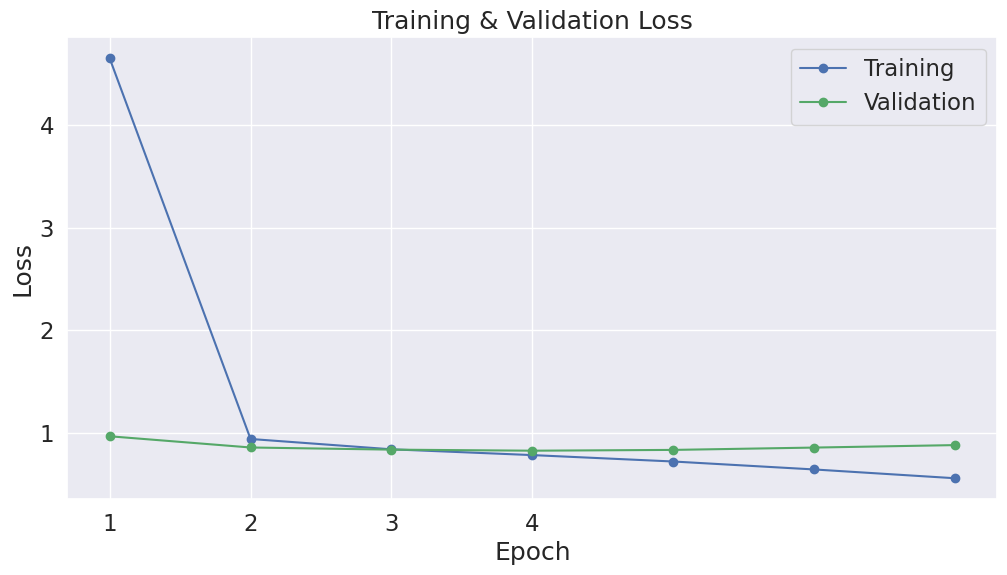

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

#pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=trainer.training_stats)
df_stats = df_stats.set_index('Epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [19]:
model_save_path = os.path.join('..', 'models', 'model.pt')
torch.save(model.state_dict(), model_save_path)

model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration, ignore_mismatched_sizes=True)

model.resize_token_embeddings(len(tokenizer))

model.load_state_dict(torch.load(model_save_path))

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

In [20]:
model.eval()

prompt = "<|startoftext|>"
output_fortunes = []

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=100
                                )

for i, sample_output in enumerate(sample_outputs):
    fortune = tokenizer.decode(sample_output, skip_special_tokens=True)
    output_fortunes.append(fortune)
    print("{}: {}\n\n".format(i, fortune))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Your own good nature begets you.


1: It is the right thing to do, but avoid angering your supervisor.


2: Your present work credits are piling up in your favor.


3: The best way to prepare an ambitious person is to do what little is done well.


4: Your heart is pure, your mind clear, and your spirit cheerful.


5: When the devil is not smiling before the cross.


6: If you take it too seriously, it might take more than you let on.


7: Nothing in the world is as precious as what is to be found in the hands of a fool.


8: It's a silly thing to do, but you must do it anyway.


9: He that has much will thinks much of doing much.


10: You will soon be confronted with the power to influence others in your own way.


11: Life may be too short, but happiness can be too much.


12: A man with a loud tie cannot make a crowd of his followers dance.


13: A good thing for a good thing is its absence from your life.


14: You have the ability to be a great leader. Your boss is too big, an

In [21]:
gen_fortune_df = pd.DataFrame({"fortunes": output_fortunes})
gen_fortune_df.head()

,fortunes
0,Your own good nature begets you.
1,"It is the right thing to do, but avoid angerin..."
2,Your present work credits are piling up in you...
3,The best way to prepare an ambitious person is...
4,"Your heart is pure, your mind clear, and your ..."


In [22]:
gen_fortune_df.shape

(100, 1)

In [23]:
gen_fortune_df.drop_duplicates().shape

(100, 1)

In [24]:
gen_fortune_df.to_csv(os.path.join('..', 'datasets', 'GPT2_generated_fortunes_100.csv'))